# Latvijas Universitātes Datorikas fakultātes
## Izstrādes kods bakalaura darbam: **Teksta sarežģītības novērtēšana latviešu valodai**
### Autors: *Māris Kalniņš* | 2024. gads
### Piezīme: Detalizētāka informācija kā kods strādā ir lasāms bakalaura darbā.

# 1. Moduļu importēšana

In [16]:
# Datu apstrādes moduļi
from google.colab import files          # Ielasīt failu
import joblib          # Lejupielādēt modeļa Pickle serializāciju priekš API izsaukumiem
import pandas as pd          # Darbs ar dokumenta tipa datiem
import re          # Regulārās izteiksmes interpretators
import requests          # Publiski pieejamas datnes saņemšana
import nltk          # Dabiskās valodas apstrādes rīks
nltk.download('punkt')
from nltk.tokenize import word_tokenize, sent_tokenize          # Tekstvienību sadalīšana pa vārdiem un teikumiem
import numpy as np          # Darbs ar Numpy masīva datu struktūru

# Mašīnapmācīšanas moduļi
from sklearn.model_selection import train_test_split          # Datu sadalīšana apmācības un validācijas kopās
from sklearn.model_selection import GridSearchCV          # Hiperparametru regulēšana, izmantojot savstarpējo validāciju (cross-validation)
from sklearn.feature_extraction.text import TfidfVectorizer          # Teksta datu konvertēšanai TF-IDF funkcijās
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.pipeline import make_pipeline          # 'Pipeline' izveidošana, kas sastāv no skalārā un loģiskās regresijas modeļa
from sklearn.linear_model import LogisticRegression          # Loģistiskās regresijas klasifikatora izveide
from sklearn.metrics import accuracy_score          # Modeļa veiktspējas novērtēšana, izmantojot precizitātes rādītāju
from sklearn.model_selection import learning_curve          # Modeļa apmācību novērtēšana, izmantojot Learning Curve metodi (Treniņa rezultāti un savstarpējā validācija)
from sklearn.metrics import f1_score          # Modeļa apmācību novērtēšana, izmantojot F1 rezultātus
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Vizualizācija
import matplotlib.pyplot as plt          # Datu vizualizācijas rīks
from wordcloud import WordCloud          # Vizualizācija, kur katra vārda fonta lielums norāda tā biežumu vai nozīmi.
import seaborn as sns          # Teksta statistikas kortežu vizualizācija

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 2. Treniņu un validācijas datu uzkopēšana

In [3]:
!ls
uploaded = files.upload()

df = pd.read_excel('VISC_LATV.xlsx')
# Izmest ārā unnamed kolonnu
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

!ls

sample_data


Saving VISC_LATV.xlsx to VISC_LATV.xlsx
sample_data  VISC_LATV.xlsx


# 3. Treniņu datu analīze & vizualizācija

## 3.1. Treniņu datu apjoms pa klasēm

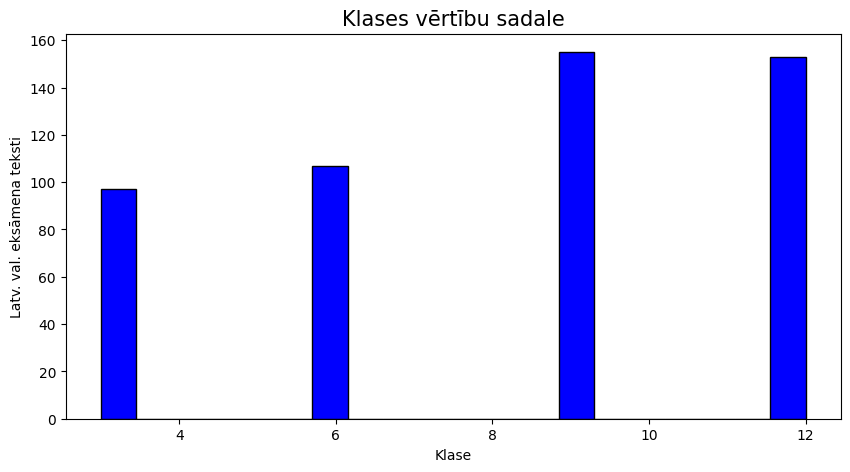

In [4]:
def plot_histogram(df_train, column, x_title=None, y_title=None, edge_color='black', color='blue', total_bins=20, font_size=10):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.hist(df_train[column], bins=total_bins, edgecolor=edge_color, color=color)
    ax.set_title(f'{column}s vērtību sadale', fontsize=font_size + 5)
    ax.set_xlabel(column if x_title is None else x_title, fontsize=font_size)
    ax.set_ylabel(y_title if y_title is not None else "Latv. val. eksāmena teksti", fontsize=font_size)
    plt.show()

plot_histogram(df, 'Klase')

## 3.2. Treniņu datu apjoms pa eksāmena gadiem

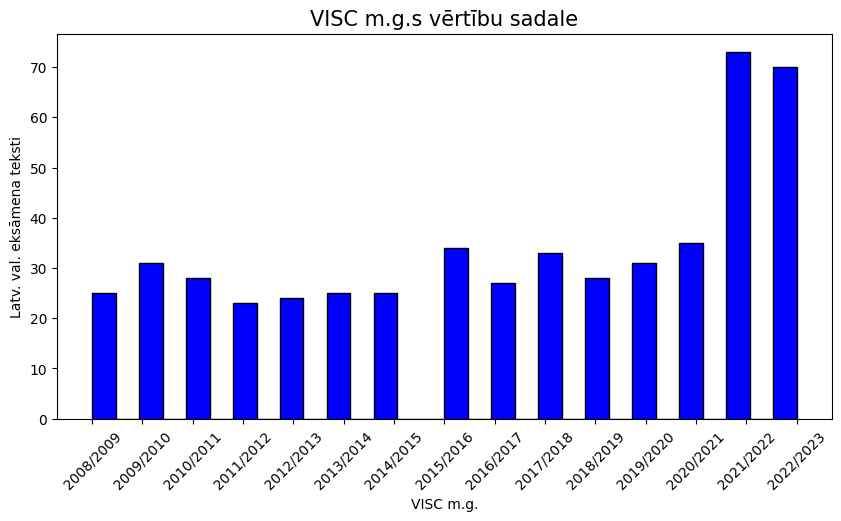

In [5]:
def plot_histogram(df, column, x_title=None, y_title=None, edge_color='black', color='blue', total_bins=20, font_size=10):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.hist(df[column], bins=total_bins, edgecolor=edge_color, color=color)
    ax.set_title(f'{column}s vērtību sadale', fontsize=font_size + 5)
    ax.set_xlabel(column if x_title is None else x_title, fontsize=font_size)
    ax.set_ylabel(y_title if y_title is not None else "Latv. val. eksāmena teksti", fontsize=font_size)
    for label in ax.get_xticklabels():
        label.set_rotation(45)

    plt.show()

plot_histogram(df, 'VISC m.g.', total_bins=30)

# 4. Treniņu datu priekšapstrāde

## 4.1. Latviešu valodas stopvārdu izsijāšana

In [6]:
stopwords_url = "https://raw.githubusercontent.com/stopwords-iso/stopwords-lv/master/stopwords-lv.json"
response = requests.get(stopwords_url)
lv_stopwords = response.json()
lv_stopwords.extend(["kas","tiem","visi","mana","kuras","savas","jūs","tas","nav","ko","cik","kad","kur","e","vēl","būtu","sevi","nekad","es","viņš","viņa","manu","savu","mēs","mūsu","viņu","tu","ļoti","man","viņas","sava","tur","kādu","tādu","mani","tās","visu","mums","daudz","nebija","viņa","kura","kuru","kurš","kāds","kāda","šī","viņai","tam","mana""tas","viņi","tie","vairs","viņam","savā","tev","šo","viss","neko","kopā","atkal"])
print(lv_stopwords)

['aiz', 'ap', 'apakš', 'apakšpus', 'ar', 'arī', 'augšpus', 'bet', 'bez', 'bija', 'biji', 'biju', 'bijām', 'bijāt', 'būs', 'būsi', 'būsiet', 'būsim', 'būt', 'būšu', 'caur', 'diemžēl', 'diezin', 'droši', 'dēļ', 'esam', 'esat', 'esi', 'esmu', 'gan', 'gar', 'iekam', 'iekams', 'iekām', 'iekāms', 'iekš', 'iekšpus', 'ik', 'ir', 'it', 'itin', 'iz', 'ja', 'jau', 'jeb', 'jebšu', 'jel', 'jo', 'jā', 'ka', 'kamēr', 'kaut', 'kolīdz', 'kopš', 'kā', 'kļuva', 'kļuvi', 'kļuvu', 'kļuvām', 'kļuvāt', 'kļūs', 'kļūsi', 'kļūsiet', 'kļūsim', 'kļūst', 'kļūstam', 'kļūstat', 'kļūsti', 'kļūstu', 'kļūt', 'kļūšu', 'labad', 'lai', 'lejpus', 'līdz', 'līdzko', 'ne', 'nebūt', 'nedz', 'nekā', 'nevis', 'nezin', 'no', 'nu', 'nē', 'otrpus', 'pa', 'par', 'pat', 'pie', 'pirms', 'pret', 'priekš', 'pār', 'pēc', 'starp', 'tad', 'tak', 'tapi', 'taps', 'tapsi', 'tapsiet', 'tapsim', 'tapt', 'tapāt', 'tapšu', 'taču', 'te', 'tiec', 'tiek', 'tiekam', 'tiekat', 'tieku', 'tik', 'tika', 'tikai', 'tiki', 'tikko', 'tiklab', 'tiklīdz', 'tik

## 4.2. Teksta normalizēšana

In [7]:
def dataPreprocessing(df):
    text_list = []
    for text in df['Teksts'].values:
        text = re.sub('[^a-zA-ZāčēģīķļņšūžĀČĒĢĪĶĻŅŠŪŽ]', ' ', str(text))
        text = text.lower()
        tokens = nltk.word_tokenize(text)
        filtered_tokens = [word for word in tokens if word not in lv_stopwords]
        text = " ".join(filtered_tokens)
        text_list.append(text)
    text_list = pd.Series(text_list, name='Teksts')
    return text_list

ProcessedText = dataPreprocessing(df)

print(ProcessedText)

0      ticis rīgā zaķis uzmeklē sēklu tirgotavu gudro...
1      ak skābu kāpostu pavisam saldā balsī iesaucās ...
2      lauris iziet cauri nelielam krūmājam kājas sāk...
3      andra mārītes māmiņai lādīte saktām vienīgā pi...
4      divtūkstoš gadus kristus dzimšanas viļņu izska...
                             ...                        
507    laimes puķe auga gausi meitene liela sāka zaro...
508    gāja garām seja baltāka krūtīs lēni spiedās ie...
509    paņēma sarkano puķi gāja tālā miglā nemanīdama...
510    meitene apsedza seju rokām vaidēdama kāpa lejā...
511    bij labi nokrita akmens klona kunkstēja sakost...
Name: Teksts, Length: 512, dtype: object


## 4.3. Visbiežāk sastopamo tokenu uzskaite pa klasēm


In [8]:
labels = df['Klase'].unique()

for label in labels:
    label_df = df[df['Klase'] == label]
    ProcessedText = dataPreprocessing(label_df)
    textplot = ''.join([str(text) for text in ProcessedText if not pd.isna(text)])
    wordcloud = WordCloud(width=700, height=700).generate(textplot)
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud)
    plt.title(f"Uzģenerētais vārdu mākonis priekš {label}. klases", fontsize=28)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

# 5. Teksta statistisko datu ieguve

## 5.1. Teksta kvantitatīvie dati

In [9]:
def dataFeatures(df, lv_stopwords):
    num_of_words = []
    teikumu_garums = []
    vid_varda_garums = []
    teksta_garums_simb = []
    teikumu_kopskaits = []

    for text in df['Teksts'].values:

        initial_length = len(text)
        teksta_garums_simb.append(initial_length)
        teikumu_skaits = len(sent_tokenize(text))
        teikumu_kopskaits.append(teikumu_skaits)
        text = re.sub('[^a-zA-Zāčēģīķļņšūž]', ' ', text)
        text = text.lower()
        text = word_tokenize(text)
        num_words = len(text)
        num_of_words.append(num_words)
        teikumu_garums.append(num_words/teikumu_skaits)
        vid_varda_garums.append(initial_length/num_words)
        text = [word for word in text if not word in lv_stopwords]
        text = " ".join(text)
        print(text)

    df = pd.concat([pd.Series(teikumu_garums), pd.Series(num_of_words),
                             pd.Series(vid_varda_garums), pd.Series(teikumu_kopskaits), pd.Series(teksta_garums_simb)], axis = 1)
    df.columns = ["Vid. teikuma garums", "Vārdu skaits", "Vid. vārda garums",
                          "Teikumu skaits", "Teksta garums simboli"]

    return df

df['Teksts'] = df['Teksts'].astype(str).apply(lambda text: text.replace('\n', ' '))
df_train = dataFeatures(df, lv_stopwords)
df_train.dropna(inplace=True)

ticis rīgā zaķis uzmeklē sēklu tirgotavu gudros ies iekšā prasīs kāpostu sēklas tirgotājs visas sēklas pārdevis pašlaik slauka pabiras jaunskungs vēlas tirgotāju vīzei laipni noprasa kāpostu sēklas zaķis bailīgi dabū lūpu kāpostu sēklas jaunskungs vēlas galviņu kāposti rožu kāposti kacenu kāposti varbūt jaunskungs ņems kacenu kāpostus vasarā ēst lapas ziemā grauzt kacenu blēdis zaķis nodomāja visādu kāpostu sēklas piesola visgaršīgākajiem vārda citādu kāpostu sēklu jums viltīgi noprasa pārdevējs noplātīja rokas gribētu skābu kāpostu sēklas drošāk uzstājās zaķis tirgotājs pavīpsnāja šis pircējs acīm redzot galīgi zaķa
ak skābu kāpostu pavisam saldā balsī iesaucās tirgotājs dodam velti saslaucīja sēklu pabiras maisiņā pasniedza zaķim dēls bāz kabatā vasarsvētkiem iesēj jāņiem ēdīsi skābu skābos ziemassvētkus nemaz negaidīsi zaķis laimīgs brauca mājā imene iesēja kāpostus mitrajā meža liekņā zaķis pats sēdēja klāt uzmanīja putni neizkasa kurmji neizrok kazas neapgrauž sieva tos ravēja rīt

In [11]:
df_train

,Vid. teikuma garums,Vārdu skaits,Vid. vārda garums,Teikumu skaits,Teksta garums simboli
0,8.285714,116,6.991379,14,811
1,9.666667,145,6.593103,15,956
2,7.111111,64,6.546875,9,419
3,10.400000,156,6.512821,15,1016
4,10.357143,145,7.241379,14,1050
...,...,...,...,...,...
507,13.750000,55,5.781818,4,318
508,13.500000,54,5.870370,4,317
509,10.000000,60,6.066667,6,364
510,8.800000,44,6.250000,5,275


## 5.2. Teksta kvantitatīvo datu sakarību vizualizācija

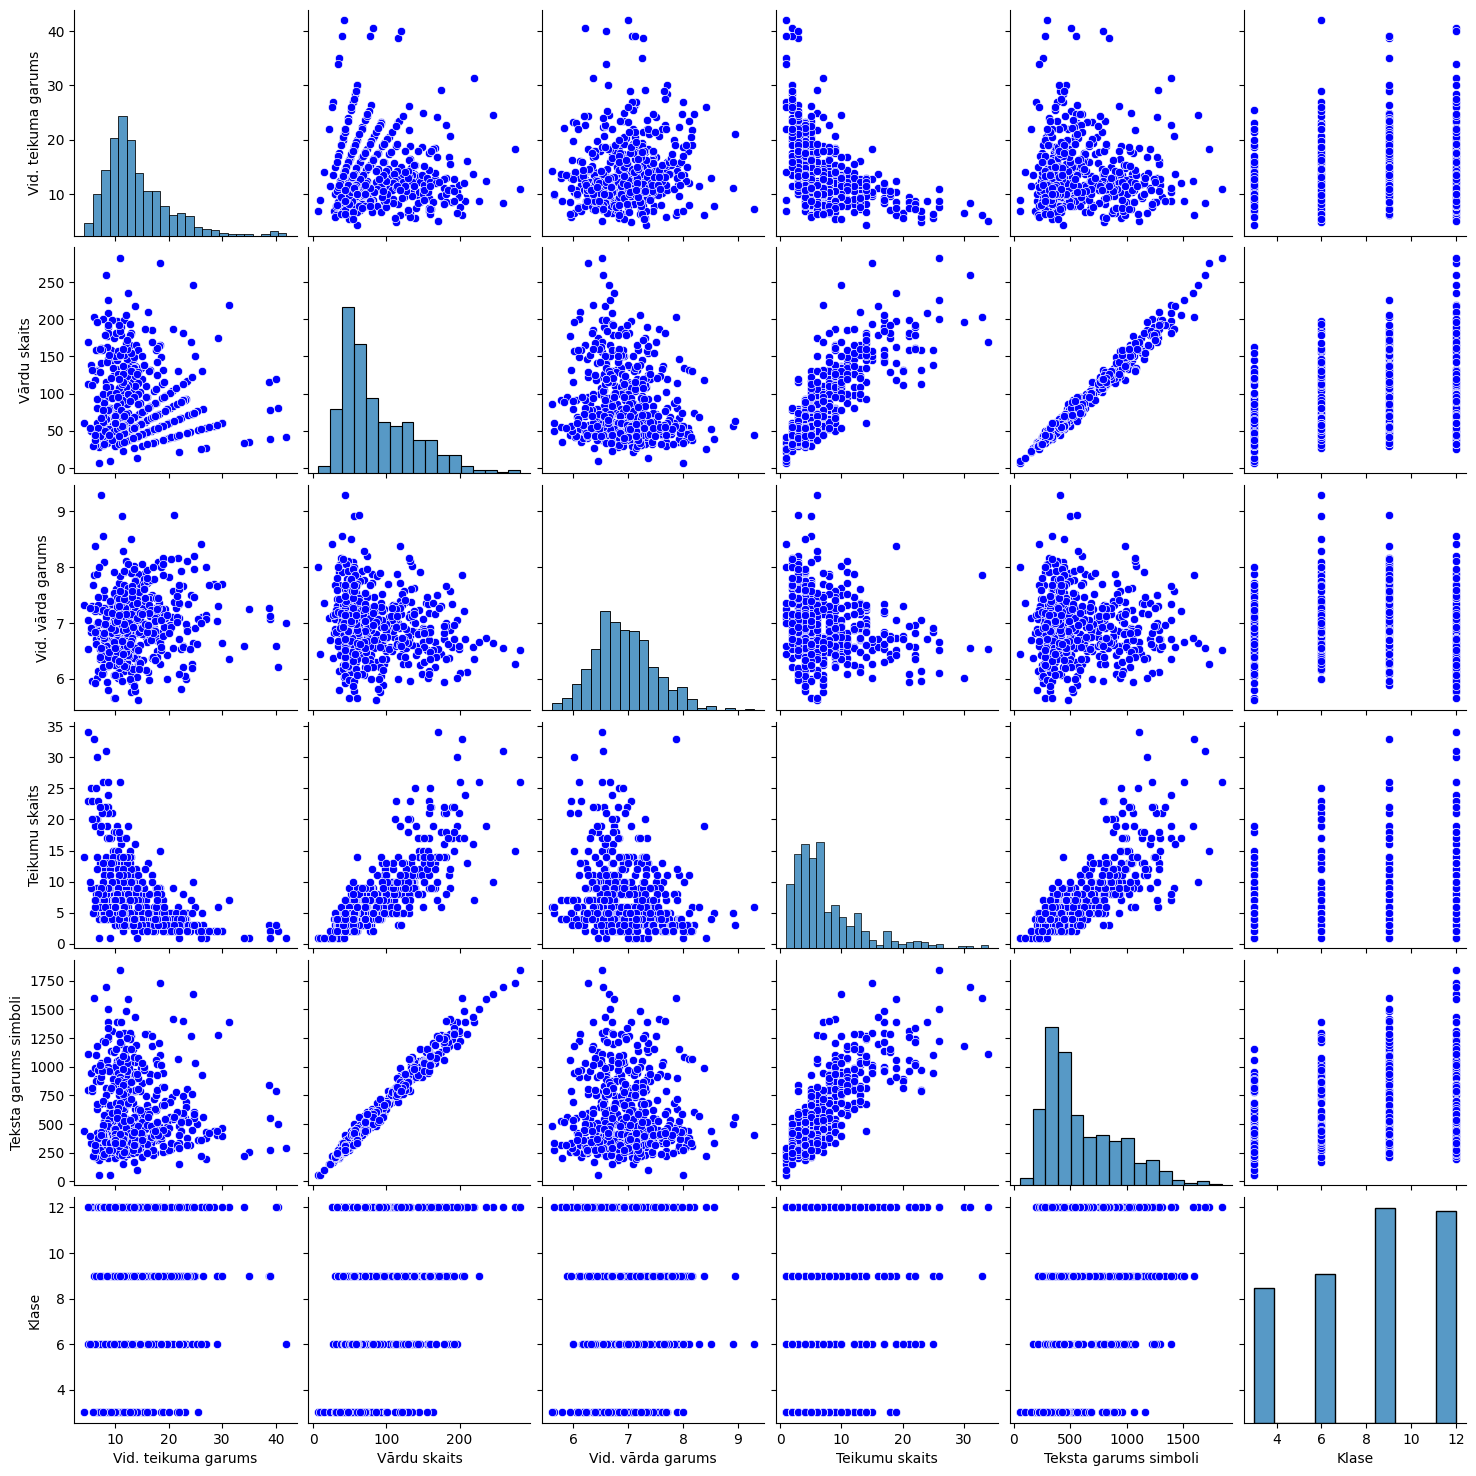

In [10]:
featurePlot = pd.concat([df_train, df['Klase']], axis = 1)
sns.pairplot(featurePlot, plot_kws = dict(color = 'blue'))
plt.show()

## 5.3. Teksta kvalitatīvo datu ieguve

In [12]:
def dataPunctuationFeatures(df: pd.DataFrame):
    komati = []
    izsauksmes_zimes = []
    jautajumu_zimes = []
    tiesa_runa = []
    punkts = []
    garakais_vards = []

    for i in range(len(df)):

        text = df['Teksts'].iloc[i]
        komati.append(text.count(","))
        izsauksmes_zimes.append(text.count("!"))
        jautajumu_zimes.append(text.count("?"))
        tiesa_runa.append(text.count('„') and text.count('”'))
        punkts.append(text.count('.'))
        word_len = [len(w) for w in text.split(" ")]
        garakais_vards.append(np.max(word_len))

    df_with_features =pd.concat((pd.Series(komati), pd.Series(izsauksmes_zimes),
                               pd.Series(jautajumu_zimes), pd.Series(tiesa_runa), pd.Series(punkts),
                                pd.Series(garakais_vards)), axis = 1)
    df_with_features.columns = ["Komatu skaits", "Izsauksmes zīmju skaits",
                                "Jautājumu zīmju skaits", "Tiešu runu pēdiņas", "Punktu zīmes skaits",
                                "Garākais vārds"]
    return df_with_features

df['Teksts'] = df['Teksts'].astype(str).apply(lambda text: text.replace('\n', ' '))
df_train_extra = dataPunctuationFeatures(df)

df_train_extra

,Komatu skaits,Izsauksmes zīmju skaits,Jautājumu zīmju skaits,Tiešu runu pēdiņas,Punktu zīmes skaits,Garākais vārds
0,14,0,3,2,12,16
1,15,1,0,0,14,13
2,3,0,0,0,9,11
3,19,0,0,0,19,14
4,12,2,1,5,20,13
...,...,...,...,...,...,...
507,4,1,0,0,3,9
508,2,0,0,0,4,11
509,4,0,0,0,6,10
510,3,0,0,0,5,10


## 5.4. Teksta kopējās statistisko datu apvienojums

In [13]:
joined_df = pd.concat((ProcessedText, df_train, df_train_extra), axis = 1)

joined_df

,Teksts,Vid. teikuma garums,Vārdu skaits,Vid. vārda garums,Teikumu skaits,Teksta garums simboli,Komatu skaits,Izsauksmes zīmju skaits,Jautājumu zīmju skaits,Tiešu runu pēdiņas,Punktu zīmes skaits,Garākais vārds
0,neviens nezina pasaule pieciem gadiem izmaiņas...,8.285714,116,6.991379,14,811,14,0,3,2,12,16
1,redzi jaunajā laikmetā vairāk sasniedz mēģina ...,9.666667,145,6.593103,15,956,15,1,0,0,14,13
2,lelde dzird pirmo aicinājumu nevar uzreiz kājā...,7.111111,64,6.546875,9,419,3,0,0,0,9,11
3,tagad tuvojoties durvīm kurām gaida tēvs pašā ...,10.400000,156,6.512821,15,1016,19,0,0,0,19,14
4,to izskaidro vaicā tēvs neapgalvosi ielikts ka...,10.357143,145,7.241379,14,1050,12,2,1,5,20,13
...,...,...,...,...,...,...,...,...,...,...,...,...
507,NaN,13.750000,55,5.781818,4,318,4,1,0,0,3,9
508,NaN,13.500000,54,5.870370,4,317,2,0,0,0,4,11
509,NaN,10.000000,60,6.066667,6,364,4,0,0,0,6,10
510,NaN,8.800000,44,6.250000,5,275,3,0,0,0,5,10


# 6. Modeļa realizācija

## 6.1. Modeļu treniņu un validācijas (testu) datu definēšana

In [24]:
X = joined_df[['Teksts', 'Vid. teikuma garums', 'Vārdu skaits', 'Vid. vārda garums', 'Teikumu skaits', 'Teksta garums simboli', 'Komatu skaits', 'Izsauksmes zīmju skaits', 'Jautājumu zīmju skaits', 'Tiešu runu pēdiņas', 'Punktu zīmes skaits', 'Garākais vārds']]
y = df['Klase']

text_data = joined_df['Teksts']

text_data.fillna('', inplace=True)

X_train, X_test, y_train, y_test = train_test_split(text_data, y, test_size=0.2, random_state=50)

vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

## 6.2. Modeļa definēšana

## 6.3. Modeļa apmācība

In [29]:
clf = make_pipeline(StandardScaler(with_mean=False), SVC(kernel=cosine_similarity))
clf.fit(X_train_vectorized, y_train)

Pipeline(steps=[('standardscaler', StandardScaler(with_mean=False)),
                ('svc',
                 SVC(kernel=<function cosine_similarity at 0x7afb88c11120>))])

# 7. Modeļa novērtēšana

## 7.1. Modeļa veiktspējas novērtējums uz jauniem datiem

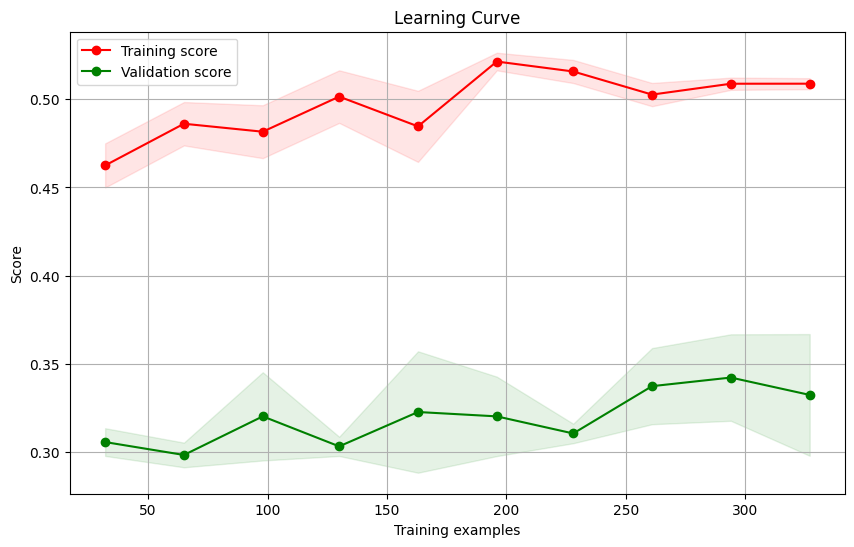

In [27]:
def plot_learning_curve(estimator, X, y, train_sizes, cv=None, scoring=None):
    train_sizes, train_scores, validation_scores = learning_curve(
        estimator, X, y, train_sizes=train_sizes, cv=cv, scoring=scoring)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, validation_scores_mean, 'o-', color="g", label="Validation score")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.title("Learning Curve")
    plt.grid()
    plt.show()

plot_learning_curve(clf, X_train_vectorized, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, scoring='accuracy')

## 7.2. Modeļa F1 rezultātu aprēķins

In [28]:
y_pred = clf.predict(X_test_vectorized)
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score:", f1)

F1 Score: 0.27565234620652823


## 7.3. Modeļa precizitātes novērtējums uz validācijas datiem

In [31]:
accuracy = clf.score(X_test_vectorized, y_test)
print("Precizitāte:", accuracy)

correct_guesses = []
incorrect_guesses = []

for i in range(len(y_pred)):
    if y_pred[i] == y_test.values[i]:
        correct_guesses.append((X_test_vectorized[i], y_test.values[i], y_pred[i]))
    else:
        incorrect_guesses.append((X_test_vectorized[i], y_test.values[i], y_pred[i]))

print("\nPareizie minējumi:")
for text, actual, predicted in correct_guesses:
    print(f"Īstais: {actual}, Minējums: {predicted}")

print("\nNepareizie minējumi:")
for text, actual, predicted in incorrect_guesses:
    print(f"Īstais: {actual}, Minējums: {predicted}")

Precizitāte: 0.3592233009708738

Pareizie minējumi:
Īstais: 12, Minējums: 12
Īstais: 12, Minējums: 12
Īstais: 12, Minējums: 12
Īstais: 12, Minējums: 12
Īstais: 12, Minējums: 12
Īstais: 12, Minējums: 12
Īstais: 12, Minējums: 12
Īstais: 12, Minējums: 12
Īstais: 9, Minējums: 9
Īstais: 9, Minējums: 9
Īstais: 9, Minējums: 9
Īstais: 12, Minējums: 12
Īstais: 12, Minējums: 12
Īstais: 12, Minējums: 12
Īstais: 12, Minējums: 12
Īstais: 9, Minējums: 9
Īstais: 9, Minējums: 9
Īstais: 9, Minējums: 9
Īstais: 9, Minējums: 9
Īstais: 12, Minējums: 12
Īstais: 9, Minējums: 9
Īstais: 12, Minējums: 12
Īstais: 12, Minējums: 12
Īstais: 12, Minējums: 12
Īstais: 12, Minējums: 12
Īstais: 12, Minējums: 12
Īstais: 12, Minējums: 12
Īstais: 12, Minējums: 12
Īstais: 12, Minējums: 12
Īstais: 9, Minējums: 9
Īstais: 9, Minējums: 9
Īstais: 12, Minējums: 12
Īstais: 12, Minējums: 12
Īstais: 12, Minējums: 12
Īstais: 12, Minējums: 12
Īstais: 9, Minējums: 9
Īstais: 9, Minējums: 9

Nepareizie minējumi:
Īstais: 6, Minējums: 12
Ī

## 7.4. Modeļa precizitātes novērtējuma vizualizācija

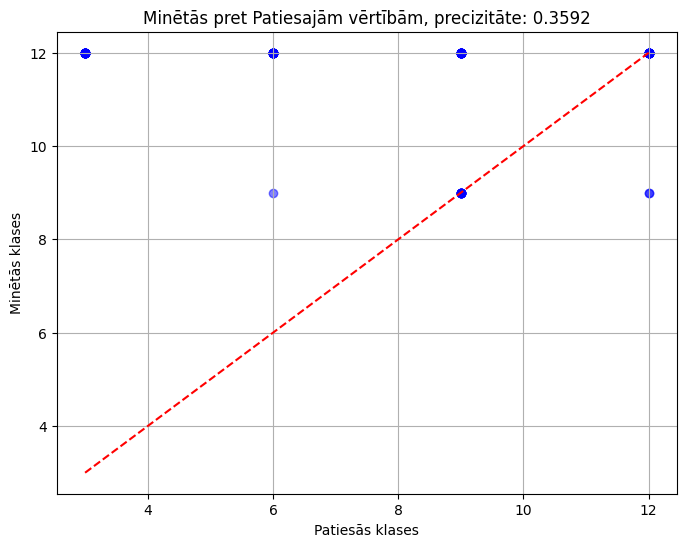

In [32]:
y_actual = y_test.values
y_predicted = y_pred

plt.figure(figsize=(8, 6))
plt.scatter(y_actual, y_predicted, color='blue', alpha=0.5)

plt.plot([min(y_actual), max(y_actual)], [min(y_actual), max(y_actual)], color='red', linestyle='--')

plt.title('Minētās pret Patiesajām vērtībām, precizitāte: '+str(round(accuracy, 4)))
plt.xlabel('Patiesās klases')
plt.ylabel('Minētās klases')
plt.grid(True)
plt.show()

## 7.5. Modeļa manuāls novērtējums uz patvaļīgiem datiem

In [36]:
# Daži īstās dzīves piemēri

# 'Bermudu Divstūru' dziesmas lirikas, https://genius.com/Bermudu-divsturis-roku-okeans-lyrics
input_text_vectorized = vectorizer.transform(['Dienā, kad nespīd vairāk saule un naktīs zvaigžņu nav, nav naktīs zvaigžņu nav, nav. Iesim, ielās tad mēs iesim, lai atkal zvaigžņu daudz daudz.'])
y_pred = clf.predict(input_text_vectorized)
print("Minējums klasei:", y_pred)

# lsm raksts par Grieķijas plūdiem, https://www.lsm.lv/raksts/zinas/arzemes/14.04.2024-griekija-atkopsanas-pec-pludiem-rosina-diskusijas-par-lauksaimniecibas-nakotni.a549747/
input_text_vectorized = vectorizer.transform(['Grieķijas iestādes nav norādījušas plūdu skartā reģiona atkopšanās grafiku, un pastāv pretrunīgi viedokļi par turpmāko rīcību. Tesālijas iestādes atbalsta liela kanāla rakšanu.'])
y_pred = clf.predict(input_text_vectorized)
print("Minējums klasei:", y_pred)

# lsm raksts par cilvēka psiholoģisku atpūtu, https://www.lsm.lv/raksts/dzive--stils/ikdienai/14.04.2024-ka-labak-atpusties-skaidro-kliniska-psihologe-marija-abeltina.a549316/
input_text_vectorized = vectorizer.transform(['"Tas, ko pētnieki saka, un ko arī praksē mēs varam novērot, ir, ka nav jau tā, ka katrs atvaļinājums un katra atpūtas dienai vai piektdienas vakars ir atpūtinošs."'])
y_pred = clf.predict(input_text_vectorized)
print("Minējums klasei:", y_pred)

Minējums klasei: [12]
Minējums klasei: [12]
Minējums klasei: [12]


# 8. Modeļa iegūšana

In [ ]:
joblib.dump(best_model, 'best_model.pkl')
files.download('best_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>